In [1]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#0-died
#1-survived

In [3]:
train = pd.read_csv('train.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')

passenger_ids = test['PassengerId']

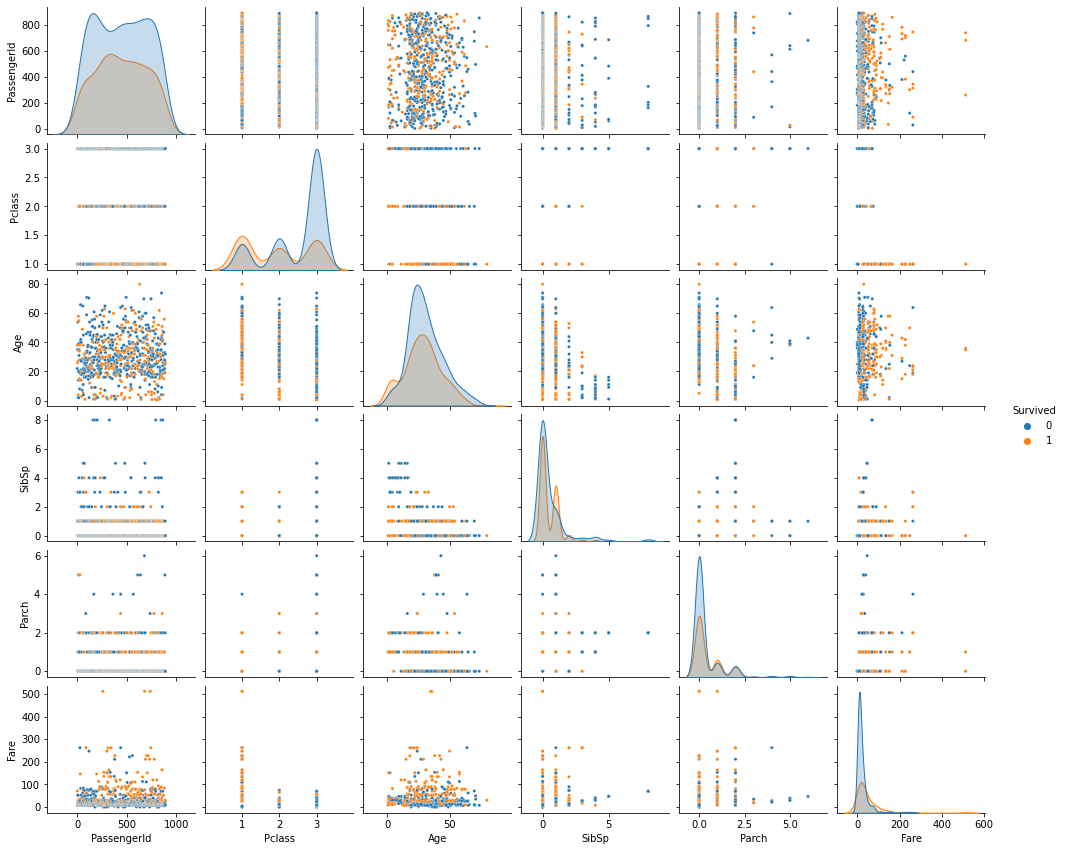

In [4]:
#quick data visualization
sns.pairplot(data=train,hue='Survived',height=2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
plt.gcf().set_size_inches(15,12)

In [5]:
train_data = train.drop(['Survived'],axis=1)
target = train['Survived']

#FEATURE ENGINEERING

def get_deck(cabin):
    if(pd.isnull(cabin) or cabin[0] == 'T'):
        return np.nan
    else:
        return cabin[0]

def checkChild(age):
    if(age <= 12):
        return 'child'
    elif(12 < age <= 17):
        return 'teenager'
    elif(age > 60):
        return 'senior'
    else:
        return 'adult'

def is_alone(passenger):
    if(passenger['SibSp'] == 0 and passenger['Parch'] == 0):
        return 1
    return 0

def get_prefix(name):
    first_part = name.split(',')[1]
    return first_part[1:].split(' ')[0][:-1]

In [6]:
#A,B represent upper decks (i.e. first class cabins)
#C,D,E are the mid decks
#F,G,U are lower decks
deck_dict = {'A':'Upper','B':'Upper','C':'Middle','D':'Middle','E':'Middle','F':'Lower','G':'Lower','U':'Lower'}

prefix_dict = {
    "Mr" :         "Mr",
    "Capt":        "Mr",
    "Col":         "Mr",
    "Major":       "Mr",
    "Dr":          "Mr",
    "Rev":         "Mr",
    "Jonkheer":    "Mr",
    "Don":         "Mr",
    "Sir" :        "Mr",
    "Mme":         "Mrs",
    "Mrs" :        "Mrs",
    "Countess":    "Mrs",
    "Dona":        "Mrs",
    "Lady" :       "Mrs",
    "Master" :     "Master", 
    "Ms":          "Miss",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
}

def create_features(data):

    data['Deck'] = data['Cabin'].apply(get_deck)
    data['Age Group'] = data['Age'].apply(checkChild)
    data['Alone'] = data[['SibSp','Parch']].apply(is_alone,axis=1)
    data['Prefix'] = data['Name'].apply(get_prefix)
    
    data['Prefix'] = data['Prefix'].map(prefix_dict)
    return data

train_data = create_features(train_data)
test = create_features(test)

prefix_group = train_data.groupby(by='Prefix').mean()
pclass_group = train_data.groupby(by='Pclass').mean()

In [7]:
def get_null_fares(passenger):
    if(pd.isnull(passenger['Fare'])):
        return pclass_group.loc[passenger['Pclass']]['Fare']
    return passenger['Fare']

def get_null_ages(passenger):
    if(pd.isnull(passenger['Age'])):
        return prefix_group.loc[passenger['Prefix']]['Age']
    return passenger['Age']

def clean_data(data): #removing any null values
    
    data['Embarked'].fillna('S',inplace=True) #fill empty embarkments with most common port (southampton)
    data['Deck'].fillna('U',inplace=True) #U stands for unknown value
    
    data['Age'] = data[['Age','Prefix']].apply(get_null_ages,axis=1)
    data['Fare'] = data[['Fare','Pclass']].apply(get_null_fares,axis=1)
                                                  
    data['Deck'] = data['Deck'].map(deck_dict)
    
    #removing unnecessary columns
    data.drop(['Cabin','PassengerId','Name','Ticket','Age','Prefix'],axis=1,inplace=True)
    return data

train_data = clean_data(train_data)
test = clean_data(test)

In [8]:
print(train_data['Embarked'].value_counts(),test['Embarked'].value_counts())

S    646
C    168
Q     77
Name: Embarked, dtype: int64 S    270
C    102
Q     46
Name: Embarked, dtype: int64


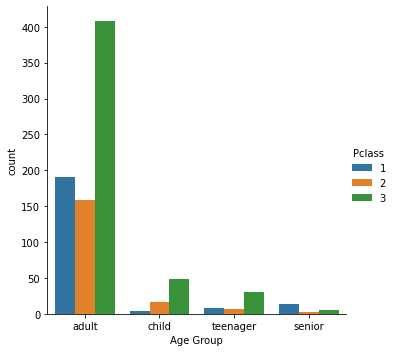

In [9]:
#More data visualization
sns.catplot(x='Age Group',data=train_data, kind='count',hue='Pclass')

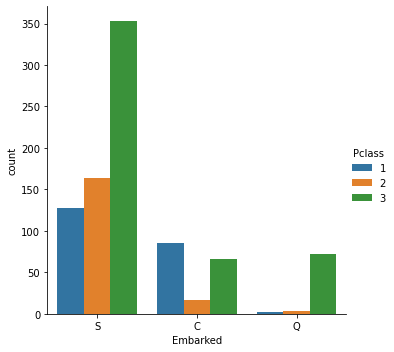

In [10]:
sns.catplot(x='Embarked',kind='count',data=train,hue='Pclass')
#large amount of passengers came from Southampton

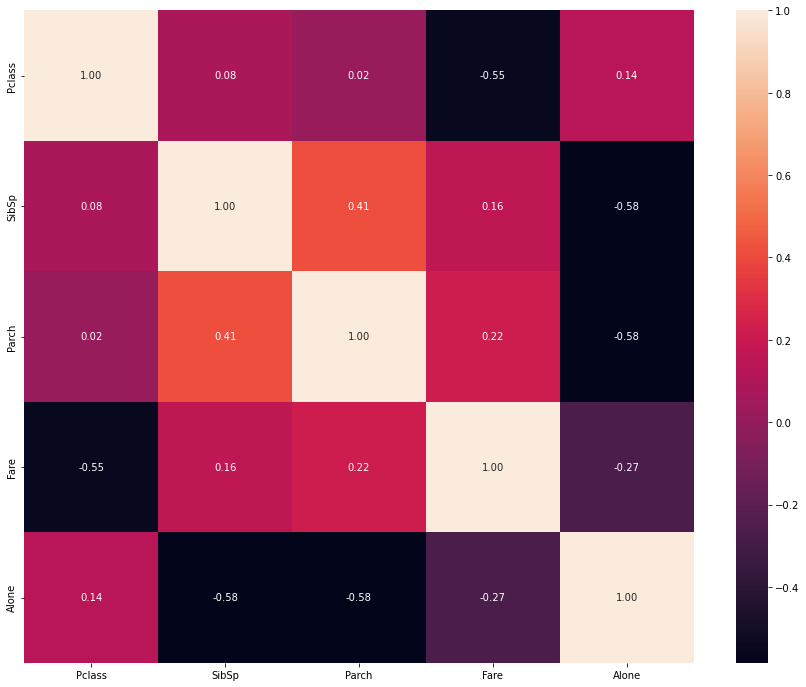

In [11]:
sns.heatmap(train_data.corr(),annot=True,fmt='.2f')
plt.gcf().set_size_inches(15,12)

In [12]:
train_data

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck,Age Group,Alone
0,3,male,1,0,7.2500,S,Lower,adult,0
1,1,female,1,0,71.2833,C,Middle,adult,0
2,3,female,0,0,7.9250,S,Lower,adult,1
3,1,female,1,0,53.1000,S,Middle,adult,0
4,3,male,0,0,8.0500,S,Lower,adult,1
...,...,...,...,...,...,...,...,...,...
886,2,male,0,0,13.0000,S,Lower,adult,1
887,1,female,0,0,30.0000,S,Upper,adult,1
888,3,female,1,2,23.4500,S,Lower,adult,0
889,1,male,0,0,30.0000,C,Middle,adult,1


In [13]:
#get dummies for non-numeric columns
def get_numeric(dataset):
    dummies = pd.get_dummies(dataset[['Sex','Embarked','Deck','Age Group']])
    dataset.drop(['Sex','Embarked','Deck','Age Group'],inplace=True,axis=1)
    new_set = pd.concat([dataset,dummies],axis=1)
    return new_set

train_data = get_numeric(train_data)
test = get_numeric(test)

In [14]:
train_data

,Pclass,SibSp,Parch,Fare,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_Lower,Deck_Middle,Deck_Upper,Age Group_adult,Age Group_child,Age Group_senior,Age Group_teenager
0,3,1,0,7.2500,0,0,1,0,0,1,1,0,0,1,0,0,0
1,1,1,0,71.2833,0,1,0,1,0,0,0,1,0,1,0,0,0
2,3,0,0,7.9250,1,1,0,0,0,1,1,0,0,1,0,0,0
3,1,1,0,53.1000,0,1,0,0,0,1,0,1,0,1,0,0,0
4,3,0,0,8.0500,1,0,1,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,13.0000,1,0,1,0,0,1,1,0,0,1,0,0,0
887,1,0,0,30.0000,1,1,0,0,0,1,0,0,1,1,0,0,0
888,3,1,2,23.4500,0,1,0,0,0,1,1,0,0,1,0,0,0
889,1,0,0,30.0000,1,0,1,1,0,0,0,1,0,1,0,0,0


In [15]:
test

,Pclass,SibSp,Parch,Fare,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_Lower,Deck_Middle,Deck_Upper,Age Group_adult,Age Group_child,Age Group_senior,Age Group_teenager
0,3,0,0,7.8292,1,0,1,0,1,0,1,0,0,1,0,0,0
1,3,1,0,7.0000,0,1,0,0,0,1,1,0,0,1,0,0,0
2,2,0,0,9.6875,1,0,1,0,1,0,1,0,0,0,0,1,0
3,3,0,0,8.6625,1,0,1,0,0,1,1,0,0,1,0,0,0
4,3,1,1,12.2875,0,1,0,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,8.0500,1,0,1,0,0,1,1,0,0,1,0,0,0
414,1,0,0,108.9000,1,1,0,1,0,0,0,1,0,1,0,0,0
415,3,0,0,7.2500,1,0,1,0,0,1,1,0,0,1,0,0,0
416,3,0,0,8.0500,1,0,1,0,0,1,1,0,0,1,0,0,0


In [16]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test = scaler.transform(test)

In [17]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

classifier_rf = RandomForestClassifier()

#testing our model by first splitting the training set
x_train, x_test, y_train, y_test = train_test_split(train_data,target,random_state=0)
classifier_rf.fit(x_train,y_train)
predictions = classifier_rf.predict(x_test)

from sklearn import metrics
print(metrics.accuracy_score(predictions,y_test))

0.8609865470852018


In [18]:
#Confusion matrix
metrics.confusion_matrix(predictions,y_test)

array([[126,  18],
       [ 13,  66]], dtype=int64)

In [19]:
#default parameters
print(classifier_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [20]:
#Hyperparameter tuning

n_estimators = [x for x in range(50,300,20)]
max_depth = [x for x in range(10,110,10)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]
max_features = ['sqrt','log2',None]

tuning_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'bootstrap': bootstrap}

In [21]:
rand_rf = RandomizedSearchCV(estimator=classifier_rf,param_distributions=tuning_grid,n_iter=150,cv=10,n_jobs=-1,verbose=2)

In [22]:
rand_rf.fit(x_train,y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 70, 90, 110, 130,
                                                         150, 170, 190, 210,
                                                         230, 250, 270, 290]},
                   verbose=2)

In [23]:
rand_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [24]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = 100 * metrics.accuracy_score(predictions,test_labels)
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(metrics.accuracy_score(predictions,test_labels)))
    
    return accuracy

#Testing best parameters against base parameters
base_param = RandomForestClassifier()
base_param.fit(x_train,y_train)
evaluate(base_param, x_test, y_test)

Model Performance
Average Error: 0.1390 degrees.
Accuracy = 0.86%.


86.09865470852019

In [25]:
#Best parameters
best_param = rand_rf.best_estimator_
evaluate(best_param, x_test, y_test)

Model Performance
Average Error: 0.1659 degrees.
Accuracy = 0.83%.


83.40807174887892

In [26]:
#Further tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

tuning_grid_2 = {'n_estimators': [rand_rf.best_params_['n_estimators'] + x for x in range(-60,61,20) if x != 0],
               'max_depth': [rand_rf.best_params_['max_depth'] + x for x in range(-10,11,5) if x != 0],
               'min_samples_split': [2,5],
               'min_samples_leaf': [2,4],
               'max_features': [None],
               'bootstrap': [True]}

print(tuning_grid_2)

tmp_classifier = RandomForestClassifier()
gridsearch_rf = GridSearchCV(estimator=tmp_classifier,param_grid=tuning_grid_2,cv=10,n_jobs=-1,verbose=2)

{'n_estimators': [150, 170, 190, 230, 250, 270], 'max_depth': [90, 95, 105, 110], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4], 'max_features': [None], 'bootstrap': [True]}


In [ ]:
gridsearch_rf.fit(x_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [ ]:
new_best_param = gridsearch_rf.best_estimator_

#compare with previous best, which was created using randomizedsearch
evaluate(best_param, x_test, y_test)

In [ ]:
evaluate(new_best_param, x_test, y_test)

In [ ]:
#This function returns a dataset formatted to kaggle submission specifications
def get_results(predictions):
    return pd.DataFrame({'PassengerId':passenger_ids.values,'Survived':predictions})

In [ ]:
#Test model on real test set
new_best_param.fit(train_data,target)
submit_pred = new_best_param.predict(test)

In [ ]:
submission_df = get_results(submit_pred)
submission_df.to_csv("results.csv",index=False)